<div style="background-color:#EAF4EC; padding:20px; border-radius:10px;">

<h2 style="color:#2F6F4E; text-align:center; margin-bottom:5px;">
Clustering Analysis — Governance Typologies
</h2>

<h4 style="color:#2F6F4E; text-align:center; margin-top:0;">
Master Thesis – ESG Governance Indicators (EU-27)
</h4>

<p style="font-size:14px; color:#000000;">
This notebook implements the <strong>Clustering</strong> stage of the CRISP-ML(Q) methodology.
The objective is to identify <strong>governance typologies</strong> among EU-27 countries based on
the previously preprocessed and scaled governance indicators before the forecasting stage.
</p>

<p style="font-size:14px; color:#000000;">
This notebook does not modify the data. It relies exclusively on the processed and scaled dataset
generated in the previous preprocessing step, ensuring methodological consistency and reproducibility.
</p>

</div>

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib.colors import ListedColormap

In [2]:
DATA_PATH = Path("../data/processed/data_scaled_governance_EU27.csv")
df_scaled = pd.read_csv(DATA_PATH)

In [3]:
df_scaled.head()

Country Name Country Code                                    Indicator Name  \
0      Austria          AUT                   Control of Corruption: Estimate   
1      Austria          AUT                             GDP growth (annual %)   
2      Austria          AUT                Government Effectiveness: Estimate   
3      Austria          AUT  Individuals using the Internet (% of population)   
4      Austria          AUT                                     Net migration   

      Indicator Code      2000      2001      2002      2003      2004  \
0             CC.EST  0.986735  0.986735  1.195920  1.258012  1.338009   
1  NY.GDP.MKTP.KD.ZG  0.177089 -0.303646 -0.260674 -0.348682  0.016821   
2             GE.EST  1.283242  1.283242  1.337701  1.420691  1.277469   
3     IT.NET.USER.ZS -1.284943 -1.061060 -1.166896 -0.918589 -0.446399   
4        SM.POP.NETM -0.197859 -0.027352 -0.045434  0.007125  0.088755   

       2005  ...      2015      2016      2017      2018      2019      2020  \
0  1.192433  ...  0.631065  0.662725  0.667747  0.754132  0.693885  0.638287   
1 -0.046049  ... -0.307103 -0.098203 -0.058402 -0.003982 -0.191201 -2.263838   
2  1.006125  ...  0.628536  0.667908  0.656246  0.637024  0.696515  0.884421   
3 -0.295786  ...  0.758501  0.774783  0.921325  0.905043  0.917255  0.905043   
4  0.055543  ...  0.550147  0.172870  0.015683 -0.062396 -0.017966 -0.029384   

       2021      2022      2023  missing_pct  
0  0.338747  0.358964  0.199706     4.166667  
1  0.589347  0.713236 -0.886923     0.000000  
2  0.756269  0.651572  0.423183     4.166667  
3  1.108573  1.153350  1.222550     0.000000  
4  0.066847  0.873676 -0.296106     0.000000  

[5 rows x 29 columns]

In [4]:
df_scaled.shape

(391, 29)

In [5]:
df_scaled.isna().sum().sum()

np.int64(0)

Although minor levels of missingness were identified during the initial data inspection, all missing values were fully addressed during preprocessing, resulting in a complete and fully observed dataset for clustering.

<div style="background-color:#EAF4EC; padding:16px; border-radius:10px;">

<h2 style="color:#2F6F4E; margin-bottom:5px; font-size:20px;">
RESHAPING THE DATASET  
</h2> 

Clustering algorithms group observations (rows). In our research question, the entity we want to group is the country (EU Member State), not the pair (country, indicator).

- Current format (long): each row is Country × Indicator with yearly values as columns.
If we clustered this table, the algorithm would group indicator-series (e.g., “Austria–CC.EST”) rather than countries.

- Required format (wide): each row must represent one country, described by the full set of governance trajectories.
We therefore reshape the data so that the features become (Indicator Code × Year), e.g., CC.EST_2000, GE.EST_2000, …

This creates a single multidimensional vector per country, making distance-based clustering meaningful.

In [6]:
# 1) Identify year columns (e.g., '2000', '2001', ...)
year_cols = [c for c in df_scaled.columns if c.isdigit()]

# 2) Pivot: one row per country, columns = (Indicator Code, Year)
# Result: index = Country Name, columns = MultiIndex (Indicator Code, Year)
df_pivot = (
    df_scaled
    .set_index(["Country Name", "Indicator Code"])[year_cols]
    .stack()                                   # -> index: (Country, Indicator, Year)
    .unstack(["Indicator Code", None])         # -> columns: (Indicator, Year)
)

# 3) Flatten MultiIndex columns into single strings: 'INDICATORCODE_YEAR'
df_pivot.columns = [f"{ind}_{year}" for ind, year in df_pivot.columns]

# 4) Quick checks
print("Shape (countries, features):", df_pivot.shape)
display(df_pivot.head())

Shape (countries, features): (27, 360)


CC.EST_2000  CC.EST_2001  CC.EST_2002  CC.EST_2003  CC.EST_2004  \
Country Name                                                                    
Austria          0.986735     0.986735     1.195920     1.258012     1.338009   
Belgium          0.598961     0.598961     0.612910     0.507503     0.488726   
Bulgaria        -1.473102    -1.473102    -1.464570    -1.356714    -1.158460   
Croatia         -1.290505    -1.290505    -0.958572    -0.915854    -0.940269   
Cyprus           0.132889     0.132889     0.190313     0.274476    -0.132233   

              CC.EST_2005  CC.EST_2006  CC.EST_2007  CC.EST_2008  CC.EST_2009  \
Country Name                                                                    
Austria          1.192433     1.182813     1.308334     1.085782     0.914044   
Belgium          0.510116     0.413394     0.472196     0.491601     0.605521   
Bulgaria        -1.221507    -1.386370    -1.540877    -1.595684    -1.537658   
Croatia         -1.067506    -1.188052    -1.170145    -1.309783    -1.355151   
Cyprus          -0.099364     0.138403     0.122862     0.275520    -0.091234   

              ...  VA.EST_2014  VA.EST_2015  VA.EST_2016  VA.EST_2017  \
Country Name  ...                                                       
Austria       ...     0.830752     0.808639     0.675329     0.815996   
Belgium       ...     0.758064     0.819854     0.789909     0.677628   
Bulgaria      ...    -2.149347    -1.956938    -2.044936    -1.964376   
Croatia       ...    -1.717740    -1.599735    -1.686973    -1.821356   
Cyprus        ...    -0.249104    -0.215166    -0.171832    -0.143508   

              VA.EST_2018  VA.EST_2019  VA.EST_2020  VA.EST_2021  VA.EST_2022  \
Country Name                                                                    
Austria          0.854751     0.673324     0.840443     0.816466     0.895777   
Belgium          0.653799     0.589649     0.501705     0.480649     0.556816   
Bulgaria        -2.153125    -2.183718    -2.460742    -2.388865    -2.378956   
Croatia         -1.917578    -1.894320    -1.529601    -1.465918    -1.422895   
Cyprus          -0.261426    -0.171479    -0.591226    -0.726588    -0.742271   

              VA.EST_2023  
Country Name               
Austria          0.888771  
Belgium          0.640088  
Bulgaria        -2.083873  
Croatia         -1.558247  
Cyprus          -0.381051  

[5 rows x 360 columns]

<div style="background-color:#EAF4EC; padding:16px; border-radius:10px;">

<h2 style="color:#2F6F4E; margin-bottom:5px; font-size:20px;">
Principal Component Analysis (PCA)
</h2> 

After reshaping the dataset, each country is represented by a high-dimensional vector (Indicator × Year), resulting in ~360 features for only 27 observations.

This creates typical issues for distance-based clustering:
- Many features are highly correlated (especially adjacent years within the same indicator).
- Distances become noisy and less informative in high-dimensional spaces.
- Clustering results may become unstable and sensitive to small fluctuations.

PCA transforms the original features into a smaller set of orthogonal components that capture most of the variance in the data.

We keep enough components to explain a predefined proportion of variance (85%–95%), ensuring that:
- the main governance patterns are preserved,
- noise and redundancy are reduced,
- clustering becomes more robust and interpretable.

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import pandas as pd

# Impute NaNs (mean)
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(df_pivot)

print("NaNs after imputation:", np.isnan(X_imputed).sum())

# PCA (keep 85% variance)
pca = PCA(n_components=0.85, random_state=42)
X_pca = pca.fit_transform(X_imputed)

print("Original shape:", df_pivot.shape)
print("PCA shape:", X_pca.shape)
print("Explained variance (total):", pca.explained_variance_ratio_.sum())

# Optional: DataFrame for convenience
df_pca = pd.DataFrame(
    X_pca,
    index=df_pivot.index,
    columns=[f"PC{i+1}" for i in range(X_pca.shape[1])]
)

df_pca.head(27)

NaNs after imputation: 0
Original shape: (27, 360)
PCA shape: (27, 5)
Explained variance (total): 0.8576167614104672


PC1        PC2        PC3        PC4       PC5
Country Name                                                         
Austria          11.770707  -1.723872  -1.389575  -1.561062 -2.180442
Belgium           9.186373  -2.856063   5.909860   5.607916  6.572490
Bulgaria        -19.935742   0.691423   5.080868  -4.806771 -1.667051
Croatia         -15.652697  -1.105095   4.077196  -1.650638  2.548594
Cyprus           -5.934136  -2.219469  -2.881582  -0.141836 -3.794659
Czechia          -4.109149  -1.752268  -1.323538  -1.174938  2.273823
Denmark          19.189492  -4.496038   2.042055  -1.121400 -2.235229
Estonia           0.653258  -4.999507   0.253764  -2.621242 -2.345132
Finland          21.914314  -6.670069   4.491370  -0.853817  2.589845
France            5.889615  10.562440   2.158661   0.653200 -2.200811
Germany          17.373065  27.261326  -5.881564  -9.018920  2.077551
Greece          -14.252026   1.193769   0.483481   5.222275  0.776213
Hungary          -9.779802  -1.888472  -1.495488  -2.279146 -0.675857
Ireland           6.562047  -4.970872  -8.437978   1.003504 -3.054444
Italy            -8.815672  11.852704  -0.335634   8.438504  0.584744
Latvia           -9.344717  -3.295632   1.121299  -3.603523 -3.292229
Lithuania        -7.026552  -3.747380   0.114885  -5.735352 -4.009677
Luxembourg       12.247870  -7.707695  -7.647717   1.579369 -1.744234
Malta            -4.978251  -3.786644 -15.628229   7.315953  5.288417
Netherlands      16.072611  -1.138340  -0.041406   0.574822 -2.362923
Poland           -8.450686   3.177403   0.702109  -1.870395  3.288346
Portugal         -0.094257  -1.909124   0.818796   0.387728 -1.821331
Romania         -22.989661   0.626012   1.901737  -2.505793  3.599554
Slovak Republic  -9.285666  -3.075936  -0.786390  -1.985873  1.359518
Slovenia         -1.869934  -2.760026   1.567503  -2.777007  1.634242
Spain            -0.090432   9.193537   7.087685  13.278178 -6.045819
Sweden           21.750028  -4.456113   8.037831  -0.353735  4.836502

PCA reduced the original dataset from 360 features to 5 principal components, explaining about 86% of the total variance.  
These components capture the main governance patterns across countries and are used as input for clustering.

<div style="background-color:#EAF4EC; padding:16px; border-radius:10px;">

<h2 style="color:#2F6F4E; margin-bottom:5px; font-size:20px;">
Clustering 
</h2> 

<div style="background-color:#EAF4EC; padding:16px; border-radius:10px;">

<h2 style="color:#2F6F4E; margin-bottom:5px; font-size:20px;">
Elbow Method
</h2> 

##### Selecting the number of clusters

Before applying clustering, the optimal number of clusters was evaluated using internal validation methods.
The elbow method and silhouette score were used to balance model compactness and cluster separation.


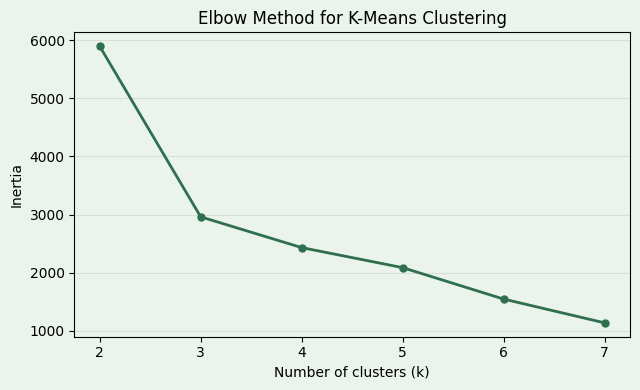

In [8]:
ACCENT = "#2F6F4E"
BACKGROUND = "#EAF4EC"

inertia = []
K_range = range(2, 8)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(df_pca)
    inertia.append(km.inertia_)

fig, ax = plt.subplots(figsize=(6.5, 4))
fig.patch.set_facecolor(BACKGROUND)
ax.set_facecolor(BACKGROUND)

ax.plot(
    K_range,
    inertia,
    marker="o",
    linewidth=2,
    markersize=5,
    color=ACCENT
)

ax.set_xlabel("Number of clusters (k)")
ax.set_ylabel("Inertia")
ax.set_title("Elbow Method for K-Means Clustering")

ax.grid(True, axis="y", alpha=0.3)
ax.grid(False, axis="x")

plt.tight_layout()
plt.show()


The elbow plot suggests k = 3 as the optimal number of clusters, as inertia decreases sharply up to this point and flattens thereafter.


<div style="background-color:#EAF4EC; padding:16px; border-radius:10px;">

<h2 style="color:#2F6F4E; margin-bottom:5px; font-size:20px;">
Sillhouette Analysis
</h2> 

In [9]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(df_pca)
    score = silhouette_score(df_pca, labels)
    print(f"k={k} | silhouette={score:.3f}")


k=2 | silhouette=0.454
k=3 | silhouette=0.406
k=4 | silhouette=0.349
k=5 | silhouette=0.291
k=6 | silhouette=0.231


Although k = 2 maximizes the silhouette score, k = 3 provides a more informative and substantively meaningful partition of EU countries and was therefore selected.


<div style="background-color:#EAF4EC; padding:16px; border-radius:10px;">

<h2 style="color:#2F6F4E; margin-bottom:5px; font-size:20px;">
CLUSTER METHODS 
</h2> 

##### Choice of clustering algorithm

K-Means was selected as the main clustering method due to its interpretability, robustness with PCA-transformed data, and suitability for small, structured datasets.

<div style="background-color:#EAF4EC; padding:16px; border-radius:10px;">

<h2 style="color:#2F6F4E; margin-bottom:5px; font-size:20px;">
K-Means Clustering
</h2> 

K-Means clustering was applied to the PCA-reduced dataset using k = 3 clusters, as determined by the elbow method and supported by silhouette analysis.

The algorithm groups countries based on their proximity in the reduced feature space, allowing the identification of distinct governance typologies across EU Member States.

In [10]:
# Apply K-Means with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
df_pca["cluster_km"] = kmeans.fit_predict(df_pca)

# Check cluster assignment by country
df_pca[["cluster_km"]].sort_values("cluster_km")
df_pca["cluster_km"].value_counts().sort_index()

cluster_km
0     1
1    17
2     9
Name: count, dtype: int64

PC0 - 1 countrie

PC1 - 17 countries

PC2 - 9 countries 

##### TOTAL - 27 Countries

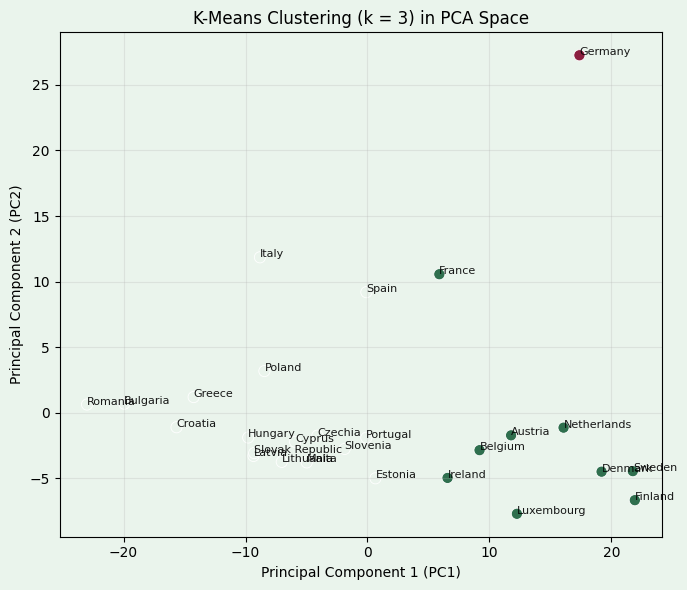

In [11]:
BACKGROUND = "#EAF4EC"

# Distinct, thesis-safe colors
cluster_colors = ["#8B1E3F", "#EAF4EC", "#2F6F4E"]
cmap = ListedColormap(cluster_colors)

fig, ax = plt.subplots(figsize=(7, 6))
fig.patch.set_facecolor(BACKGROUND)
ax.set_facecolor(BACKGROUND)

scatter = ax.scatter(
    df_pca["PC1"],
    df_pca["PC2"],
    c=df_pca["cluster_km"],
    cmap=cmap,
    s=65,
    edgecolor="white",
    linewidth=0.6
)

# Country labels
for country in df_pca.index:
    ax.text(
        df_pca.loc[country, "PC1"],
        df_pca.loc[country, "PC2"],
        country,
        fontsize=8,
        alpha=0.9
    )

ax.set_xlabel("Principal Component 1 (PC1)")
ax.set_ylabel("Principal Component 2 (PC2)")
ax.set_title("K-Means Clustering (k = 3) in PCA Space")

ax.grid(True, alpha=0.25)

plt.tight_layout()
plt.show()

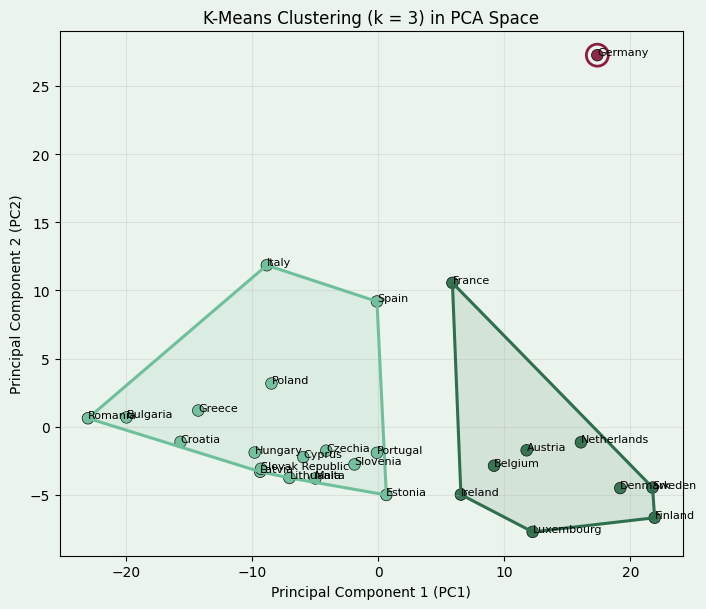

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

BACKGROUND = "#EAF4EC"

# Cluster colors (your palette)
cluster_colors = ["#8B1E3F", "#6FBF9B", "#2F6F4E"]
cmap = ListedColormap(cluster_colors)

# Try convex hull; if scipy not available, we'll fallback later
try:
    from scipy.spatial import ConvexHull
    HAS_SCIPY = True
except Exception:
    HAS_SCIPY = False

fig, ax = plt.subplots(figsize=(7.2, 6.2))
fig.patch.set_facecolor(BACKGROUND)
ax.set_facecolor(BACKGROUND)

# Scatter
ax.scatter(
    df_pca["PC1"], df_pca["PC2"],
    c=df_pca["cluster_km"],
    cmap=cmap,
    s=70,
    edgecolor="black",
    linewidth=0.5,
    alpha=0.95
)

# Labels
for country in df_pca.index:
    ax.text(df_pca.loc[country, "PC1"], df_pca.loc[country, "PC2"], country, fontsize=8)

# Draw hulls (or fallback)
for k, col in enumerate(cluster_colors):
    pts = df_pca[df_pca["cluster_km"] == k][["PC1", "PC2"]].to_numpy()

    if pts.shape[0] < 3:
        # Too few points to form a hull; just skip or draw a small circle around them
        ax.scatter(pts[:, 0], pts[:, 1], s=250, facecolor="none", edgecolor=col, linewidth=2)
        continue

    if HAS_SCIPY:
        hull = ConvexHull(pts)
        hull_pts = pts[hull.vertices]
        # Close the polygon
        hull_pts = np.vstack([hull_pts, hull_pts[0]])

        ax.plot(hull_pts[:, 0], hull_pts[:, 1], color=col, linewidth=2.2)
        ax.fill(hull_pts[:, 0], hull_pts[:, 1], color=col, alpha=0.12)
    else:
        # Fallback: draw a simple ellipse-ish region (approx) using covariance
        mean = pts.mean(axis=0)
        cov = np.cov(pts.T)
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]

        # 2-sigma ellipse scale (you can tweak)
        t = np.linspace(0, 2*np.pi, 200)
        ellipse = np.stack([np.cos(t), np.sin(t)])
        scale = 2.2 * np.sqrt(vals)
        ellipse = (vecs @ (ellipse * scale[:, None])).T + mean

        ax.plot(ellipse[:, 0], ellipse[:, 1], color=col, linewidth=2.2)
        ax.fill(ellipse[:, 0], ellipse[:, 1], color=col, alpha=0.12)

ax.set_xlabel("Principal Component 1 (PC1)")
ax.set_ylabel("Principal Component 2 (PC2)")
ax.set_title("K-Means Clustering (k = 3) in PCA Space")
ax.grid(True, alpha=0.25)

plt.tight_layout()
plt.show()


#### K-Means clustering in PCA

The PC1–PC2 plot shows a clear separation between governance profiles.
Countries such as Finland, Sweden, Denmark, the Netherlands and Austria appear on the right-hand side (high PC1), forming a high-governance cluster.
Countries like Romania, Bulgaria and Croatia are positioned on the left-hand side (low PC1), reflecting weaker or catching-up governance profiles.

Germany appears clearly isolated from the remaining countries, indicating a distinct governance structure.
Overall, the visualization confirms that K-Means identifies meaningful and interpretable governance typologies across EU countries.


<div style="background-color:#EAF4EC; padding:16px; border-radius:10px;">

<h2 style="color:#2F6F4E; margin-bottom:5px; font-size:20px;">
Hierarchical Clustering
</h2> 

To assess the robustness of the K-Means solution, hierarchical clustering using Ward linkage was applied to the PCA-reduced data.
This complementary approach allows verification of whether similar governance groupings emerge independently of the clustering algorithm.

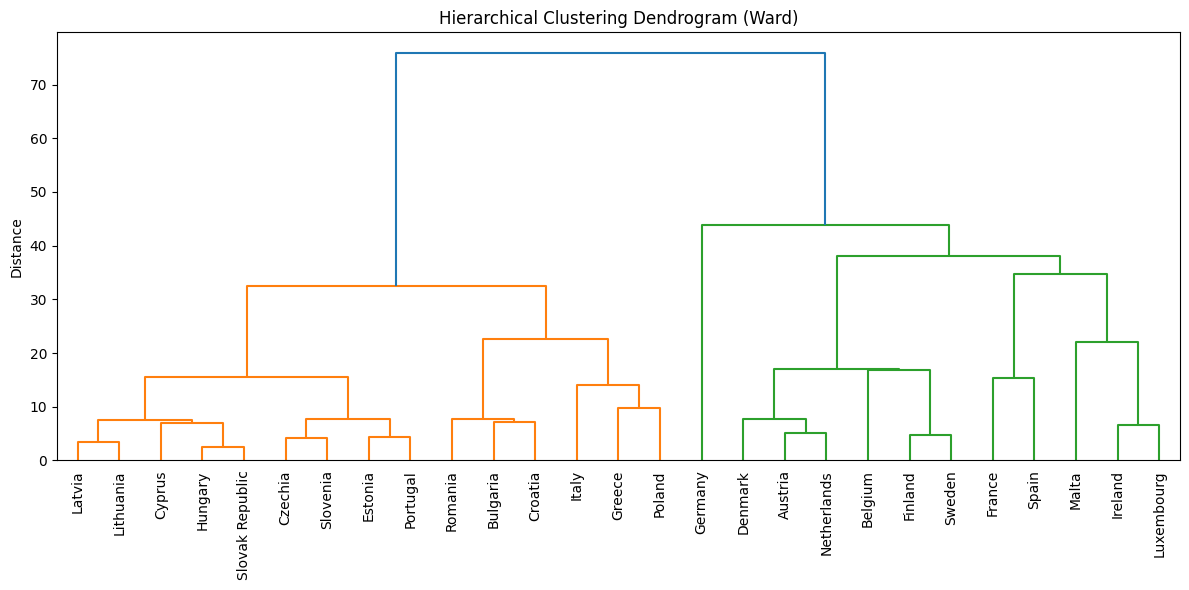

In [13]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Hierarchical clustering (Ward)
Z = linkage(df_pca, method="ward")

plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    labels=df_pca.index,
    leaf_rotation=90
)
plt.title("Hierarchical Clustering Dendrogram (Ward)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

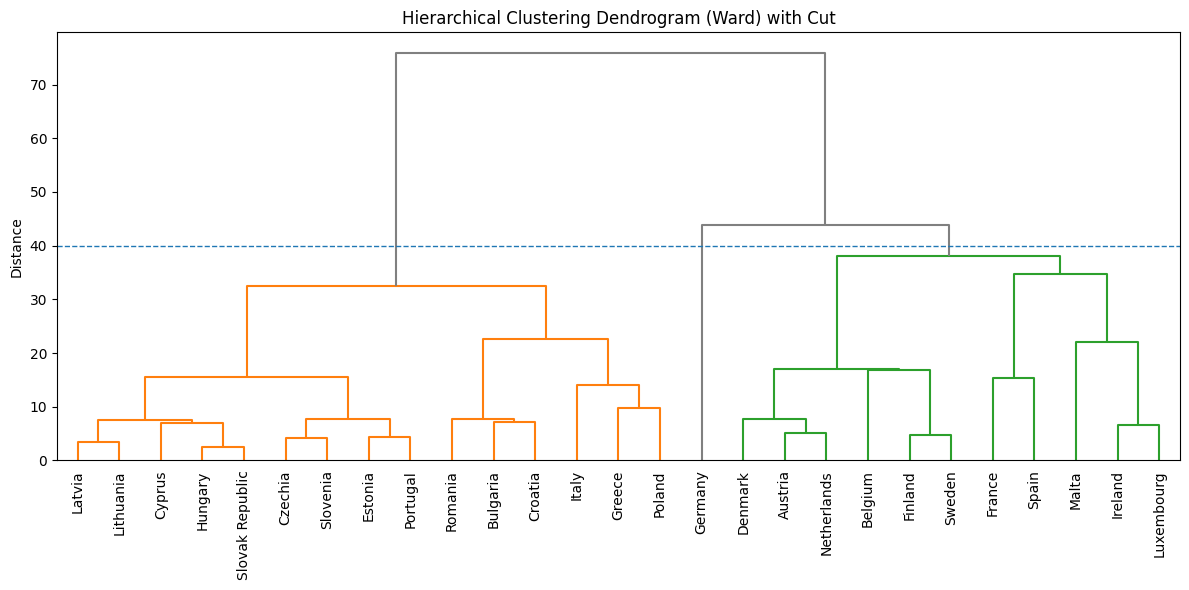

cluster_hc_cut
Country Name                   
Romania                       1
Slovenia                      1
Bulgaria                      1
Croatia                       1
Cyprus                        1
Czechia                       1
Slovak Republic               1
Estonia                       1
Lithuania                     1
Portugal                      1
Poland                        1
Greece                        1
Hungary                       1
Latvia                        1
Italy                         1
Austria                       2
Netherlands                   2
Malta                         2
Ireland                       2
Spain                         2
France                        2
Finland                       2
Denmark                       2
Belgium                       2
Luxembourg                    2
Sweden                        2
Germany                       3

In [14]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# 1) Linkage (se ainda não tiveres Z)
Z = linkage(df_pca, method="ward")

# 2) Define a altura de corte (ajusta se quiseres)
cut_height = 40

plt.figure(figsize=(12, 6))

dendrogram(
    Z,
    labels=df_pca.index,
    leaf_rotation=90,
    color_threshold=cut_height,        # <-- cores mudam abaixo do corte
    above_threshold_color="grey"       # <-- acima do corte fica cinzento
)

# 3) Desenha a linha do corte
plt.axhline(y=cut_height, linestyle="--", linewidth=1)

plt.title("Hierarchical Clustering Dendrogram (Ward) with Cut")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# 4)Obter labels dos clusters a partir do corte por distância
df_pca["cluster_hc_cut"] = fcluster(Z, t=cut_height, criterion="distance")
df_pca[["cluster_hc_cut"]].sort_values("cluster_hc_cut")

The dendrogram was cut at the level preceding the largest increase in linkage distance.
This cut yields three main clusters, corresponding to distinct governance typologies.
The result is consistent with the K-Means solution, confirming the robustness of the clustering structure.

Hierarchical clustering (Ward) confirms the K-Means structure, identifying two broad governance groups and one structurally distinct country.

<div style="background-color:#EAF4EC; padding:16px; border-radius:10px;">

<h2 style="color:#2F6F4E; margin-bottom:5px; font-size:20px;">
Types of Governance According to Clustering
</h2> 

## Governance cluster typologies

Based on the combined results of K-Means and hierarchical clustering, three governance typologies were identified among EU countries.

The first cluster, labelled *Lower Governance*, includes countries with lower values along the main governance dimension and greater internal heterogeneity, reflecting weaker institutional performance or ongoing convergence processes.

The second cluster, labelled *High Governance*, groups countries with consistently high institutional quality and strong governance performance. This cluster is relatively compact, indicating structural similarity and stability.

The third cluster consists of a single country and is labelled *Structurally Distinct Governance*. This cluster reflects an exceptional governance profile that is markedly different from the remaining EU Member States, highlighting the presence of significant institutional heterogeneity within the Union.